In [1]:
import numpy as np
from pandas.tools.plotting import scatter_matrix
from pymatgen import Composition, Element, MPRester, periodic_table
from sklearn import linear_model, cross_validation, ensemble
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from IPython.display import Image

In [2]:
df = pd.DataFrame()   # Creating a Pandas data frame to store all the collected data from MP

In [3]:
allBinaries = itertools.combinations(periodic_table.all_symbols(), 2)  # Create list of all binary systems

In [4]:
API_KEY = None  # Enter your key received from Materials Project

if API_KEY is None:
    m = MPRester()
else:
    m = MPRester(API_KEY)

In [5]:
for system in allBinaries:
    results = m.get_data(system[0] + '-' + system[1], data_type='vasp')  # Download DFT data for each binary system
    for material in results:  # We will receive many compounds within each binary system
        if material['e_above_hull'] < 1e-6:  # Check if this compound is thermodynamically stable
            dat = [material['pretty_formula'], material['band_gap'], material['formation_energy_per_atom'],
                   material['density']]
            df = df.append(pd.Series(dat), ignore_index=True)

In [6]:
df.columns = ['materials', 'bandgaps','formenergies','densities'] # Inserting column headers in the data frame

In [7]:
MAX_Z = 100  # maximum length of vector to hold naive feature set

In [8]:
def naive_vectorize(composition):
    '''
    :param composition: pymatgen Composition object
    :return: length-100 vector representing any chemical formula
    '''
    vector = np.zeros(MAX_Z)
    for ele in composition:
        fraction = composition.get_atomic_fraction(ele)
        vector[ele.Z - 1] = fraction
    return vector

In [9]:
def extract_vectors(x):
    '''
    :param x: Pandas data frame object
    :return: tuple containing the naive feature set
    '''
    mater = Composition(x)
    return tuple(naive_vectorize(mater))

In [10]:
# Constructing naive feature set and adding it to the DF
df1 = df.copy()
df1['naiveFeatures'] = df1['materials'].apply(extract_vectors)

In [11]:
# Establish baseline accuracy by "guessing the average" of the band gap set
# A good model should never do worse.
baselineError = np.mean(abs(np.mean(df1[['bandgaps']]) - df1[['bandgaps']]))
print("The MAE of always guessing the average band gap is: " + str(round(baselineError, 3)) + " eV")

The MAE of always guessing the average band gap is: 0.73 eV


In [12]:
# alpha is a tuning parameter affecting how regression deals with collinear inputs
linear = linear_model.Ridge(alpha=0.5)

cv = cross_validation.ShuffleSplit(len(df1), n_iter=10, test_size=0.1, random_state=0)

scores = cross_validation.cross_val_score(linear, list(df1['naiveFeatures']), df1['bandgaps'], cv=cv,
                                          scoring='mean_absolute_error')

print("The MAE of the linear ridge regression band gap model using the naive feature set is: " \
      + str(round(abs(np.mean(scores)), 3)) + " eV")

The MAE of the linear ridge regression band gap model using the naive feature set is: 0.464 eV


In [13]:
# Let's see which features are most important for the linear model

print(
"Below are the fitted linear ridge regression coefficients for each feature (i.e., element) in our naive feature set")

linear.fit(list(df1['naiveFeatures']), df1['bandgaps'])  # fit to the whole data set; we're not doing CV here

print("element: coefficient")

for i in range(MAX_Z):
    element = Element.from_Z(i + 1)
    print(element.symbol + ': ' + str(linear.coef_[i]))

Below are the fitted linear ridge regression coefficients for each feature (i.e., element) in our naive feature set
element: coefficient
H: 1.96142001144
He: 0.0
Li: 0.444221649299
Be: 0.195760741221
B: 0.248485361583
C: 0.362223963055
N: 1.69504655724
O: 2.28205501737
F: 3.87323972555
Ne: 0.0
Na: 0.688785503417
Mg: 0.0177127541226
Al: -0.00431320109378
Si: 0.309155286972
P: 0.6279892507
S: 1.22174333821
Cl: 2.80293292807
Ar: 0.0
K: 0.990519617795
Ca: 0.0973760711906
Sc: -0.402415289569
Ti: -0.696466778148
V: -0.694444834861
Cr: -0.76213627085
Mn: -0.510703102398
Fe: -0.41356262473
Co: -0.366548903428
Ni: -0.301910461187
Cu: -0.381100299615
Zn: -0.152028740998
Ga: -0.0668456068874
Ge: 0.00623062454018
As: 0.356393660762
Se: 0.668092096336
Br: 2.40131065179
Kr: -0.0557971010417
Rb: 0.752101549977
Sr: 0.153851201024
Y: -0.2686429742
Zr: -0.53040355467
Nb: -0.913241486354
Mo: -0.641871837573
Tc: -0.47314050909
Ru: -0.303348349043
Rh: -0.3211588663
Pd: -0.309260427885
Ag: -0.488962160654
C

In [14]:
def extract_physical_features(x):
    """
    Create alternative feature set that is more physically-motivated
    :param x: Pandas data frame
    :return: a tuple of physical features
    """
    these_features = []
    fraction = []
    atomicno = []
    eneg = []
    group = []

    for elem in Composition(x[0]):
        fraction.append(Composition(x[0]).get_atomic_fraction(elem))
        atomicno.append(float(elem.Z))
        eneg.append(elem.X)
        group.append(float(elem.group))

    # We want to sort this feature set
    # according to which element in the binary compound is more abundant
    must_reverse = False

    if fraction[1] > fraction[0]:
        must_reverse = True

    for features in [fraction, atomicno, eneg, group]:
        if must_reverse:
            features.reverse()
    these_features.append(fraction[0] / fraction[1])
    these_features.append(eneg[0] - eneg[1])
    these_features.append(group[0])
    these_features.append(group[1])
    these_features.append(x[2])
    these_features.append(x[3])
    return tuple(these_features)


df1['physicalFeatures'] = df1.apply(extract_physical_features, axis=1)

scores = cross_validation.cross_val_score(linear, list(df1['physicalFeatures']), df1['bandgaps'], cv=cv,
                                          scoring='mean_absolute_error')

print("The MAE of the linear ridge regression band gap model using the physical feature set is: " \
      + str(round(abs(np.mean(scores)), 3)) + " eV")

The MAE of the linear ridge regression band gap model using the physical feature set is: 0.562 eV


In [15]:
rfr = ensemble.RandomForestRegressor(n_estimators=10) #try 10 trees in the forest

scores = cross_validation.cross_val_score(rfr, list(df1['naiveFeatures']), df1['bandgaps'], cv=cv, scoring='mean_absolute_error')

print("The MAE of the nonlinear random forest band gap model using the naive feature set is: "\
	+ str(round(abs(np.mean(scores)), 3)) + " eV")

scores = cross_validation.cross_val_score(rfr, list(df1['physicalFeatures']), df1['bandgaps'], cv=cv, scoring='mean_absolute_error')

print("The MAE of the nonlinear random forest band gap model using the physical feature set is: " \
      + str(round(abs(np.mean(scores)), 3)) + " eV")

The MAE of the nonlinear random forest band gap model using the naive feature set is: 0.348 eV
The MAE of the nonlinear random forest band gap model using the physical feature set is: 0.23 eV


In [19]:
ax = scatter_matrix(df1)
plt.savefig('output_figs/scatter_plot.png')


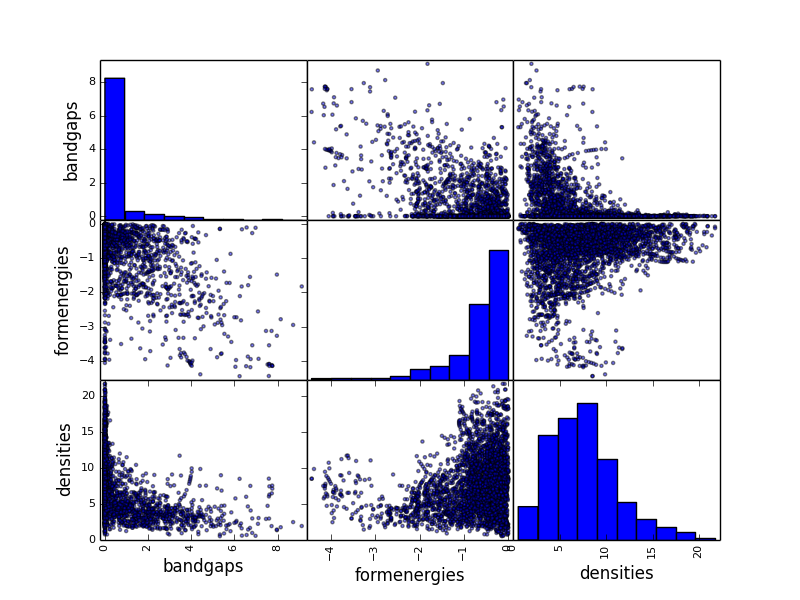

In [20]:
Image("scatter_plot.png")